In [31]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sktime.datasets import load_UCR_UEA_dataset
from sktime.classification.shapelet_based import ShapeletTransformClassifier

from sklearn.metrics import classification_report, precision_recall_fscore_support 

import warnings
warnings.filterwarnings('ignore')

In [32]:
X_train, y_train = load_UCR_UEA_dataset(name="Strawberry",
                                        split='train', 
                                        return_type='numpy3D',
                                        extract_path="./data")
X_test, y_test = load_UCR_UEA_dataset(name="Strawberry",
                                      split='test', 
                                      return_type='numpy3D',
                                      extract_path='./data')

In [33]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(613, 1, 235) (613,)
(370, 1, 235) (370,)


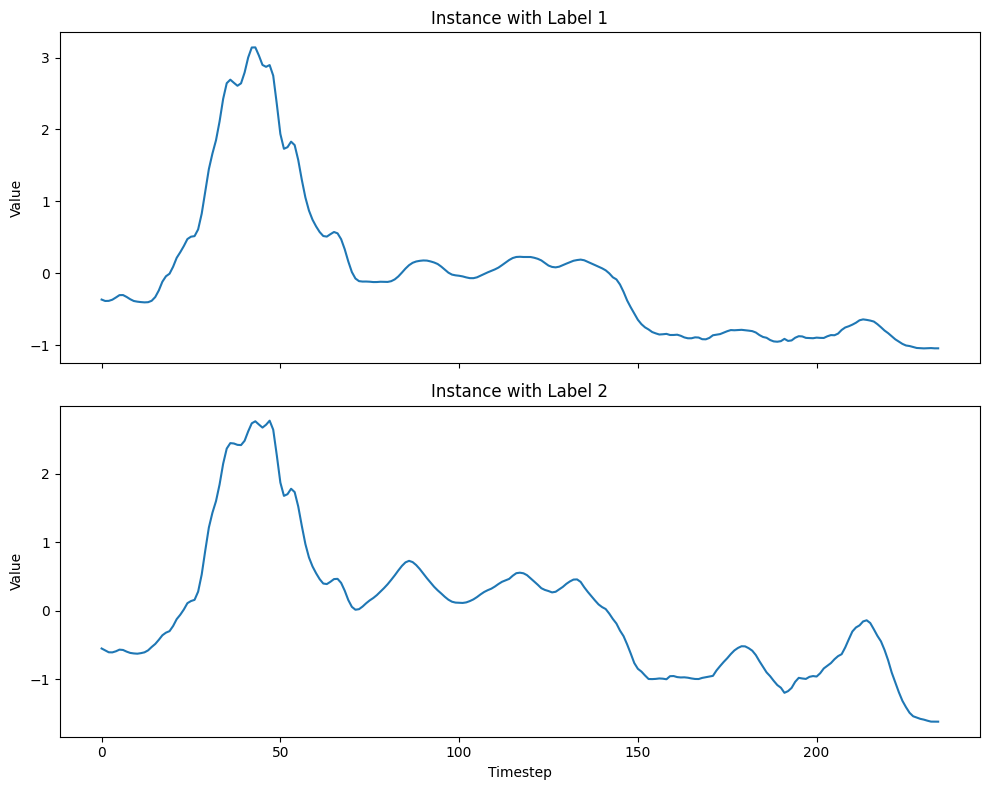

In [34]:
def find_instance_with_label(X, y, label):
    indices = np.where(y == label)[0]
    if len(indices) == 0:
        raise ValueError(f"No instance found with label {label}")
    instance = X[indices[0]]
    
    return instance

instance_label_1 = find_instance_with_label(X_train, y_train, '1')
instance_label_2 = find_instance_with_label(X_train, y_train, '2')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

lines1 = ax1.plot(instance_label_1.T)
ax1.set_ylabel("Value")
ax1.set_title("Instance with Label 1")

lines2 = ax2.plot(instance_label_2.T)
ax2.set_xlabel("Timestep")
ax2.set_ylabel("Value")
ax2.set_title("Instance with Label 2")

plt.tight_layout()
plt.show()

## Visualizing the shapelet transform

In [35]:
from pyts.transformation import ShapeletTransform

In [36]:
indices_1 = np.where(y_train == '1')[0]
indices_2 = np.where(y_train == '2')[0]

selected_indices_1 = np.random.choice(indices_1, size=50, replace=False)
selected_indices_2 = np.random.choice(indices_2, size=50, replace=False)

selected_indices = np.concatenate([selected_indices_1, selected_indices_2])

X_train_selected = X_train[selected_indices]
y_train_selected = y_train[selected_indices]

In [37]:
st = ShapeletTransform(window_sizes=[12, 48],
                       random_state=42, sort=True)

X_train_squeezed = np.squeeze(X_train_selected, axis=1)
X_new = st.fit_transform(X_train_squeezed, y_train_selected)

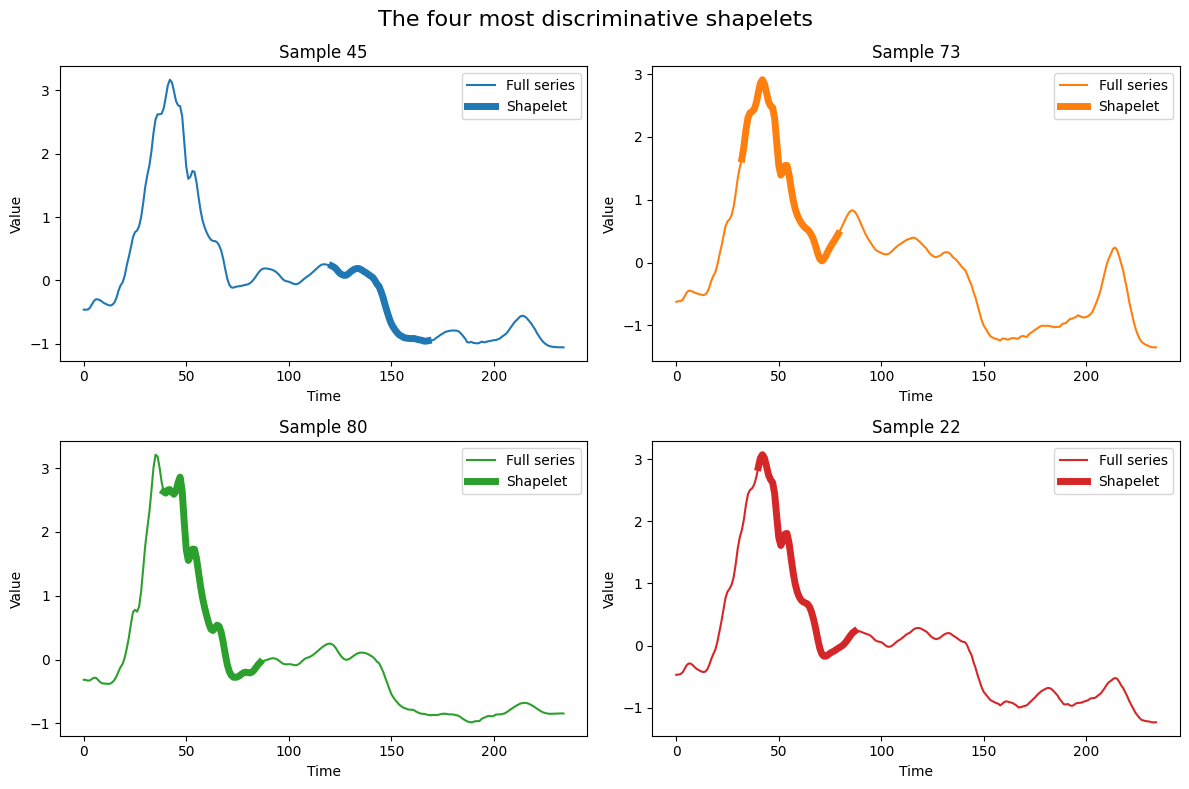

In [39]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('The four most discriminative shapelets', fontsize=16)

for i, index in enumerate(st.indices_[:4]):
    idx, start, end = index
    row = i // 2
    col = i % 2
    
    # Plot the full time series
    axs[row, col].plot(X_train_squeezed[idx], color='C{}'.format(i),
                       label='Full series')
    
    # Plot the shapelet
    axs[row, col].plot(np.arange(start, end), X_train_squeezed[idx, start:end],
                       lw=5, color='C{}'.format(i), label='Shapelet')
    
    axs[row, col].set_title(f'Sample {idx}')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Value')
    axs[row, col].legend(loc='best')

plt.tight_layout()
plt.show()

## Shapelet classifier

In [5]:
%%time

clf = ShapeletTransformClassifier(
    n_shapelet_samples=100,
    max_shapelets=100,
    time_limit_in_minutes=5,
    contract_max_n_shapelet_samples=100,
    n_jobs=-1,
    random_state=42
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

clf_report = classification_report(y_test, y_pred)

print(clf_report)

              precision    recall  f1-score   support

           1       0.94      0.97      0.96       132
           2       0.98      0.97      0.97       238

    accuracy                           0.97       370
   macro avg       0.96      0.97      0.96       370
weighted avg       0.97      0.97      0.97       370

CPU times: total: 5min 28s
Wall time: 5min 48s
